In [70]:
# pip install --upgrade google-cloud-bigquery
# pip install pydata-google-auth
# pip install db-dtypes

# Authenticate with Google BigQuery

In [1]:
# Authenticate through your browser with you Big Query account
import pydata_google_auth

scopes = ['https://www.googleapis.com/auth/bigquery']

credentials = pydata_google_auth.get_user_credentials(
    scopes,
    # Set auth_local_webserver to True for a more convenient flow,
    # but be aware it may not work on a remote server
    # like a cloud-hosted notebook if there are network restrictions
    # auth_local_webserver=True, # Optional
)

In [2]:
from google.cloud import bigquery

project = 'product-project-463105'

client = bigquery.Client(project=project,credentials=credentials)
google_ecomm = '`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`'

# Run the query to grab funnel data from Google Analytics 4 eComm Sample Dataset

In [43]:
query = f'''


-- Funnel
WITH funnel_events AS (
  SELECT 
    user_pseudo_id,
    event_timestamp,
    event_name,
    CASE 
      WHEN event_name = 'page_view' THEN 1
      WHEN event_name = 'view_item' THEN 2
      WHEN event_name = 'add_to_cart' THEN 3
      WHEN event_name = 'begin_checkout' THEN 4
      WHEN event_name = 'purchase' THEN 5
    END as funnel_step
  FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE _TABLE_SUFFIX BETWEEN '20210101' AND '20210131'
    AND event_name IN ('page_view', 'view_item', 'add_to_cart', 'begin_checkout', 'purchase')
), add_user_counts AS
(
SELECT 
  funnel_step,
  event_name,
  COUNT(DISTINCT user_pseudo_id) as unique_users,
  LAG(COUNT(DISTINCT user_pseudo_id)) OVER(ORDER BY funnel_step) prev_users
FROM funnel_events
WHERE funnel_step IS NOT NULL
GROUP BY 1, 2
)

SELECT 
  funnel_step,
  event_name,
  unique_users,
  prev_users - unique_users dropoff_users,
  COALESCE(ROUND(unique_users / prev_users *100,1),100) step2step_cvr,
  ROUND(LAST_VALUE(unique_users) OVER(ORDER BY funnel_step) / FIRST_VALUE(unique_users) OVER(ORDER BY funnel_step) * 100,1) step_v_total_cvr,
  -- You don't really need this because it's the last cvr in the previous column, but if you only want this value you here's the calculation
  ROUND(FIRST_VALUE(unique_users) OVER(ORDER BY funnel_step DESC) / FIRST_VALUE(unique_users) OVER(ORDER BY funnel_step) * 100,1) overall_cvr


FROM add_user_counts
WHERE funnel_step IS NOT NULL

ORDER BY 1


'''

funnel_df = client.query(query).to_dataframe()
funnel_df

C:\Users\benw3\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



,funnel_step,event_name,unique_users,dropoff_users,step2step_cvr,step_v_total_cvr,overall_cvr
0,1,page_view,94630,<NA>,100.0,100.0,1.1
1,2,view_item,19629,75001,20.7,20.7,1.1
2,3,add_to_cart,3832,15797,19.5,4.0,1.1
3,4,begin_checkout,1924,1908,50.2,2.0,1.1
4,5,purchase,1069,855,55.6,1.1,1.1


In [79]:
# convert the columns to lists to use in visualizations
event_names = funnel_df['event_name'].to_list()
unique_users = funnel_df['unique_users'].to_list()
drop_users = funnel_df['dropoff_users'].to_list()
step2step_cvr = funnel_df['step2step_cvr'].to_list()

# Use plotly to create a funnel visualization

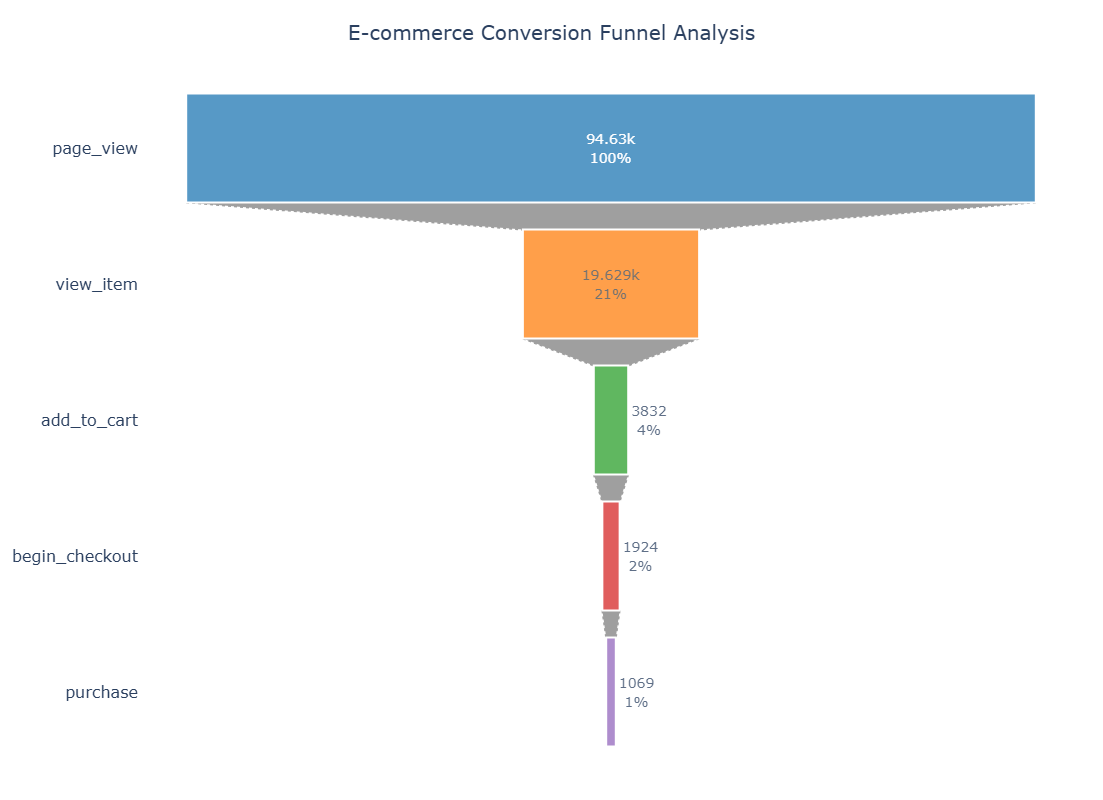

In [73]:
import plotly.graph_objects as go

# funnel data
funnel_data = {
    'stage': event_names,
    'users': unique_users
}

# Create figure and set text to appear outside funnel as needed using the "auto" text position setting
fig = go.Figure(go.Funnel(
    y=funnel_data['stage'],
    x=funnel_data['users'],
    textposition="auto",  # Let Plotly choose best position
    textinfo="value+percent initial",  # Simplified text
    textfont_size=14,     # Larger base font size
    opacity=0.75,
    marker={
        "color": ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"],
        "line": {"width": 2, "color": "white"}
    },
    connector={"line": {"color": "gray", "dash": "dot", "width": 2}}
))

# funnel layout
fig.update_layout(
    title={
        'text': "E-commerce Conversion Funnel Analysis",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    font_size=16,         # Increased overall font size
    width=1000,
    height=800,           # Taller to give more room
    margin=dict(l=20, r=20, t=80, b=40),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.show()

# Also Create a Sankey Chart to Visualize as a Flow that Shows Dropoffs as Well

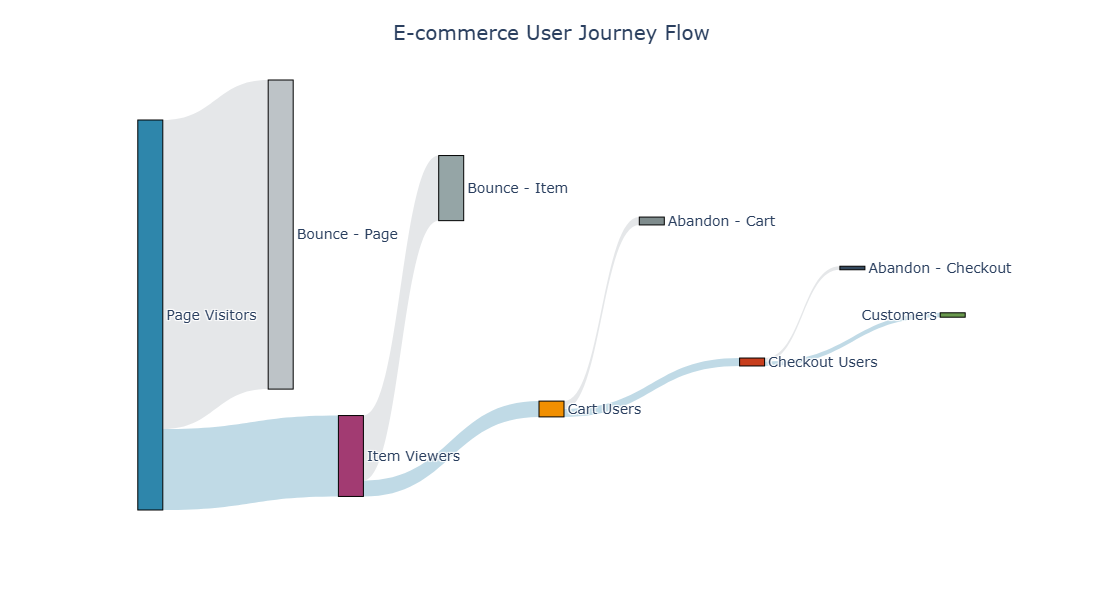

In [71]:
import plotly.graph_objects as go

# More logical node arrangement
nodes = [
    'Page Visitors',    # 0
    'Item Viewers',     # 1  
    'Cart Users',         # 2
    'Checkout Users',     # 3
    'Customers',          # 4
    'Bounce - Page',  # 5
    'Bounce - Item',   # 6
    'Abandon - Cart',     # 7
    'Abandon - Checkout'  # 8
]

# Professional color scheme
node_colors = [
    '#2E86AB',  # Visitors - Blue
    '#A23B72',  # Product Viewers - Purple
    '#F18F01',  # Cart Users - Orange
    '#C73E1D',  # Checkout - Red
    '#6A994E',  # Customers - Green
    '#BDC3C7',  # Bounces - Light Gray
    '#95A5A6',  # Bounces - Gray
    '#7F8C8D',  # Abandons - Dark Gray
    '#34495E'   # Abandons - Darker Gray
]

# Clear flows with realistic e-commerce data
flows = [
    # Main funnel
    (0, 1, unique_users[1:2]),    # Visitors → Product Viewers
    (1, 2, unique_users[2:3]),    # Product Viewers → Cart Users
    (2, 3, unique_users[3:4]),     # Cart Users → Checkout
    (3, 4, unique_users[4:5]),     # Checkout → Customers
    
    # Drop-offs at each stage
    (0, 5, drop_users[1:2]),    # Visitors bounce (never view products)
    (1, 6, drop_users[2:3]),    # Product viewers bounce (never add to cart)
    (2, 7, drop_users[3:4]),     # Cart abandonment
    (3, 8, drop_users[4:5]),     # Checkout abandonment
]

# Create cleaner Sankey
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',  # Better automatic arrangement
    node = dict(
        pad = 20,
        thickness = 25,
        line = dict(color = "black", width = 1),
        label = nodes,
        color = node_colors,
        x = [0.1, 0.3, 0.5, 0.7, 0.9,   # Main funnel x-positions
             0.23, 0.4, 0.6, 0.8],       # Drop-off x-positions
        y = [0.5, 0.8, 0.7, 0.6, 0.5,   # Main funnel y-positions
             0.1, 0.23, 0.3, 0.4]        # Drop-off y-positions
    ),
    link = dict(
        source = [f[0] for f in flows],
        target = [f[1] for f in flows],
        value = [f[2] for f in flows],
        color = ['rgba(46, 134, 171, 0.3)' if f[1] < 5 else 'rgba(189, 195, 199, 0.4)' 
                for f in flows]  # Different colors for main flow vs drop-offs
    )
)])

fig.update_layout(
    title={
        'text': "E-commerce User Journey Flow",
        'x': 0.5,
        'font': {'size': 20}
    },
    font_size=14,
    width=1200,
    height=600,
    margin=dict(l=50, r=50, t=80, b=50)
)

fig.show()

# The Original Funnel is Visually Unappealing 
* The Lowest Stages Have 2% and 1% Conversion Rates
## Instead...
* Focus in on Engaged Users by Starting with Item Views
* Highlight the Step by Step Conversion Rate Rather than the Overall Conversion Rate

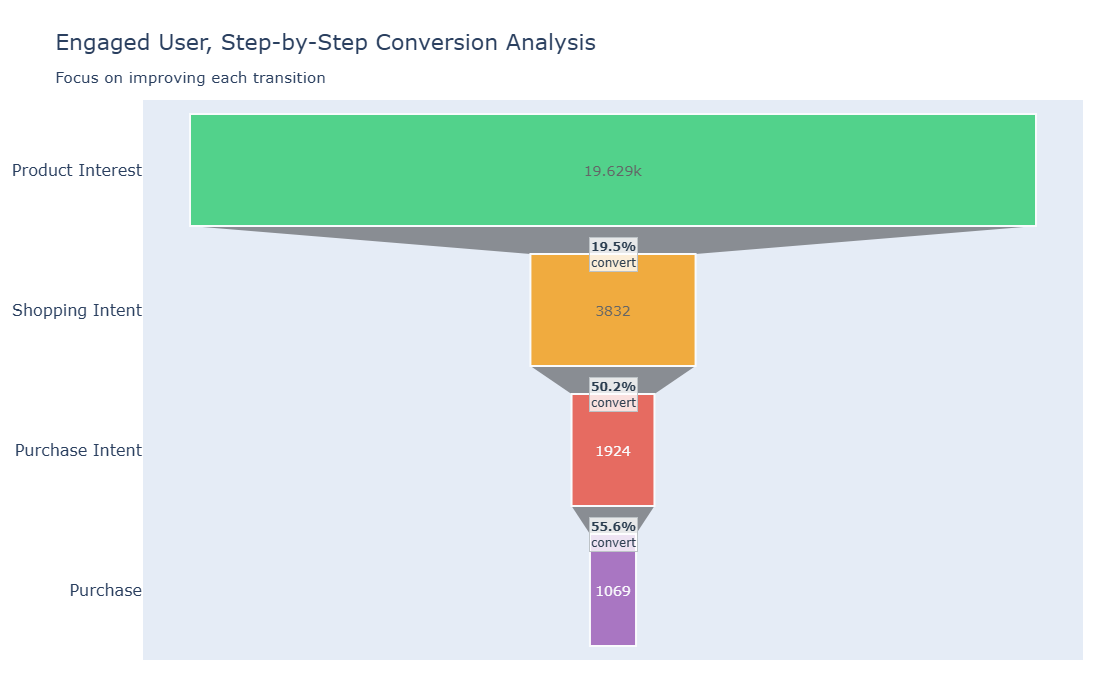

In [87]:
# Focus on only the engaged steps and on step-by-step improvements rather than overall conversion
step_conversion_data = {
    # 'stage': event_names[1:],
    'stage': ['Product Interest', 'Shopping Intent', 'Purchase Intent', 'Purchase'],
    'users': unique_users[1:],
    'step_rates': step2step_cvr[1:]  # Conversion from previous step
}

fig = go.Figure()

# Add funnel
fig.add_trace(go.Funnel(
    y=step_conversion_data['stage'],
    x=step_conversion_data['users'],
    textposition="inside",
    textinfo="value",
    textfont_size=14,
    opacity=0.8,
    marker={
        "color": ["#2ecc71", "#f39c12", "#e74c3c", "#9b59b6"],
        "line": {"width": 2, "color": "white"}
    }
))

# Add step conversion rate annotations
for i, (stage, rate) in enumerate(zip(step_conversion_data['stage'][1:], 
                                     step_conversion_data['step_rates'][1:])):
    fig.add_annotation(
        x=0,
        y=i+0.6,
        text=f"<b>{rate:.1f}%</b><br>convert",
        showarrow=False,
        font=dict(size=12, color="#2c3e50"),
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="#bdc3c7",
        borderwidth=1,
        xanchor="center"
    )

fig.update_layout(
    title="Engaged User, Step-by-Step Conversion Analysis<br><sub>Focus on improving each transition</sub>",
    font_size=16,
    width=1000,
    height=700,
    margin=dict(l=20, r=20, t=100, b=40)
)

fig.show()